In [3]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt

import utils as ut
import model_make as md
import run as run
import args as args

import time
from fastprogress import master_bar, progress_bar


import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch import optim

import torchvision.transforms as transforms
import torchvision

from PIL import Image
from pytorch_grad_cam import GradCAM
# Other methods available: ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.cm as mpl_color_map

In [6]:
train_df, val_df, test_df = ut.dataloader()

In [5]:
rows_to_drop = test_df.apply(lambda x: ut.drop_all_zeros(x), axis=1)
rows_to_drop.dropna()
test_df = test_df.drop(rows_to_drop.dropna().index).reset_index(drop=True)

In [4]:
rows_to_drop = val_df.apply(lambda x: ut.drop_all_zeros(x), axis=1)
rows_to_drop.dropna()
val_df = val_df.drop(rows_to_drop.dropna().index).reset_index(drop=True)

In [7]:
test_df

,Path,LabelOne,LabelZero,LabelMulti
0,CheXpert-v1.0-small/valid/patient64541/study1/...,"[0, 1, 0, 0]","[0, 1, 0, 0]","[0, 1, 0, 0]"
1,CheXpert-v1.0-small/valid/patient64545/study1/...,"[1, 0, 0, 1]","[1, 0, 0, 1]","[1, 0, 0, 1]"
2,CheXpert-v1.0-small/valid/patient64546/study1/...,"[1, 1, 0, 0]","[1, 1, 0, 0]","[1, 1, 0, 0]"
3,CheXpert-v1.0-small/valid/patient64548/study1/...,"[1, 1, 1, 1]","[1, 1, 1, 1]","[1, 1, 1, 1]"
4,CheXpert-v1.0-small/valid/patient64549/study1/...,"[0, 1, 0, 0]","[0, 1, 0, 0]","[0, 1, 0, 0]"
...,...,...,...,...
121,CheXpert-v1.0-small/valid/patient64732/study1/...,"[0, 1, 0, 0]","[0, 1, 0, 0]","[0, 1, 0, 0]"
122,CheXpert-v1.0-small/valid/patient64734/study1/...,"[1, 0, 0, 0]","[1, 0, 0, 0]","[1, 0, 0, 0]"
123,CheXpert-v1.0-small/valid/patient64735/study1/...,"[1, 0, 0, 0]","[1, 0, 0, 0]","[1, 0, 0, 0]"
124,CheXpert-v1.0-small/valid/patient64738/study1/...,"[0, 1, 0, 0]","[0, 1, 0, 0]","[0, 1, 0, 0]"


In [8]:
img_path = r"E:\Courses"
train_dataset = ut.ChestXrayDataset(img_path,train_df, args.IMAGE_SIZE, True,'u-ones')
val_dataset = ut.ChestXrayDataset(img_path, val_df, args.IMAGE_SIZE, True,'u-ones')
test_dataset = ut.ChestXrayDataset(img_path, test_df, args.IMAGE_SIZE, True,'u-ones')

In [9]:
testing_dataloader = DataLoader(dataset=test_dataset, batch_size=args.BATCH_SIZE, shuffle=False, 
                            num_workers=0, pin_memory=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=args.BATCH_SIZE, shuffle=False, 
                            num_workers=0, pin_memory=True)

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [11]:
efficientmodel=md.EfficientNetB3(num_classes=args.NUM_CLASSES).to(device)
state = torch.load('efficientnet.pth', map_location=device)
efficientmodel.load_state_dict(state["model"])

<All keys matched successfully>

In [12]:
import os
import cv2

In [20]:
index = 3
label_index = 1
image_index = 0

In [18]:
test_dataset[index][label_index]

tensor([1., 1., 1., 1.])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


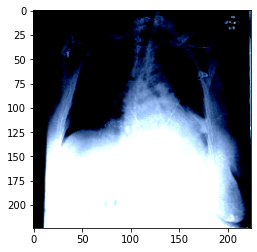

In [25]:
plt.imshow(test_dataset[index][image_index].permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


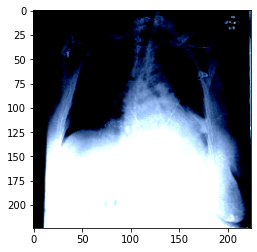

In [24]:
plt.imshow(test_dataset[index][image_index].permute(1, 2, 0))
inputtensor = test_dataset[index][image_index]
img = cv2.imread(os.path.join(img_path, test_df.Path.iloc[index]))
img = cv2.resize(img, (224, 224))
plt.show()

In [22]:
img = cv2.resize(img, (224, 224))
img = np.float32(img) / 255

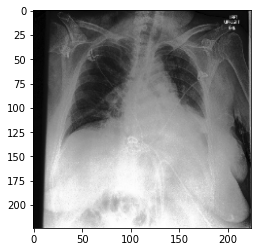

In [23]:
plt.imshow(img)

In [30]:
def display_images(dataset, index, map='rgb'):
    label_index = 1
    image_index = 0
    img_path = r"E:\Courses"
    
    if map == 'rgb':
        plt.imshow(dataset[index][image_index].permute(1, 2, 0))
        
    elif map=='gray':
        img = cv2.imread(os.path.join(img_path, test_df.Path.iloc[index]))
        img = cv2.resize(img, (224, 224))
        img = np.float32(img) / 255
        plt.imshow(img)
        
    else:
        print("Incorrect Map. Please input rgb or gray")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


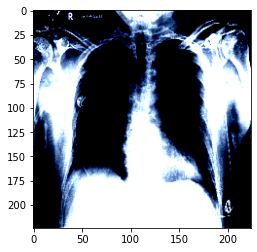

In [39]:
display_images(test_dataset, 10, 'rgb')

In [40]:
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

In [103]:
efficientmodel=md.EfficientNetB3(num_classes=args.NUM_CLASSES).to(device)
state = torch.load('efficientnet.pth', map_location=device)
efficientmodel.load_state_dict(state["model"])

<All keys matched successfully>

In [142]:
label_list[label]

'PleuralEffusion'

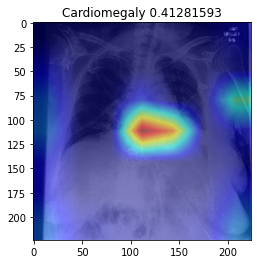

In [151]:
label = 1
target_layer = efficientmodel.model.features[-1]
cam = GradCAM(model=efficientmodel, target_layers=target_layer, use_cuda=False)
model_cmaps = [mpl_color_map.Purples, mpl_color_map.copper, mpl_color_map.Greens, mpl_color_map.Oranges]
targets = [ClassifierOutputTarget(label)]

class_labels = new_df[[label_list[label]]]
class_prob = class_labels.loc[index].values[0]
inputtensor = test_dataset[index][image_index]
inputtensor = inputtensor.unsqueeze(0)
inputtensor=inputtensor.cuda()

with GradCAM(model=efficientmodel, target_layers=target_layer) as cam:
    grayscale_cams = cam(input_tensor=inputtensor, targets=targets)
    cam_image = show_cam_on_image(img/255, grayscale_cams[0, :], use_rgb=True)
cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255*img),cam,cam_image))
plt.imshow(cam_image)
plt.title(label_list[label] + ' ' + str(class_prob))
plt.show()

In [76]:
def get_probs(model, dataloader, device):
    out_pred = torch.FloatTensor().to(device)
    with torch.no_grad(): # Turn off gradient
        # For each batch
        for step, (images, _) in tqdm(enumerate(dataloader)):
            # Move images, labels to device (GPU)
            images = images.to(device)

            # Feed forward the model
            ps = model(images)
            out_pred = torch.cat((out_pred, ps), dim=0)
    
    return out_pred

In [80]:
out_pred = get_probs(efficientmodel, testing_dataloader, device)

16it [00:00, 20.29it/s]


In [69]:
from tqdm import tqdm

out_pred = torch.FloatTensor().to(device)
with torch.no_grad(): # Turn off gradient
    # For each batch
    for step, (images, _) in tqdm(enumerate(testing_dataloader)):
        # Move images, labels to device (GPU)
        images = images.to(device)

        # Feed forward the model
        ps = efficientmodel(images)
        out_pred = torch.cat((out_pred, ps), dim=0)

16it [00:01, 12.84it/s]


In [82]:
def assign_probs(original_df, out_pred):
    new_df = original_df.assign(Atelectasis=0, Cardiomegaly=0, Consolidation = 0, PleuralEffusion=0)
    label_list = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'PleuralEffusion']
    for col in new.columns[4:]:
        new_df[col] = out_pred[:, label_list.index(col)].cpu().numpy()
    return new_df

In [84]:
new_df = assign_probs(test_df, out_pred)
new_df

,Path,LabelOne,LabelZero,LabelMulti,Atelectasis,Cardiomegaly,Consolidation,PleuralEffusion
0,CheXpert-v1.0-small/valid/patient64541/study1/...,"[0, 1, 0, 0]","[0, 1, 0, 0]","[0, 1, 0, 0]",0.382415,0.431667,0.172969,0.140582
1,CheXpert-v1.0-small/valid/patient64545/study1/...,"[1, 0, 0, 1]","[1, 0, 0, 1]","[1, 0, 0, 1]",0.459068,0.113227,0.321965,0.660598
2,CheXpert-v1.0-small/valid/patient64546/study1/...,"[1, 1, 0, 0]","[1, 1, 0, 0]","[1, 1, 0, 0]",0.472223,0.137536,0.175824,0.531446
3,CheXpert-v1.0-small/valid/patient64548/study1/...,"[1, 1, 1, 1]","[1, 1, 1, 1]","[1, 1, 1, 1]",0.520911,0.412816,0.395889,0.619753
4,CheXpert-v1.0-small/valid/patient64549/study1/...,"[0, 1, 0, 0]","[0, 1, 0, 0]","[0, 1, 0, 0]",0.072840,0.972585,0.050796,0.092459
...,...,...,...,...,...,...,...,...
121,CheXpert-v1.0-small/valid/patient64732/study1/...,"[0, 1, 0, 0]","[0, 1, 0, 0]","[0, 1, 0, 0]",0.245717,0.790590,0.124238,0.240461
122,CheXpert-v1.0-small/valid/patient64734/study1/...,"[1, 0, 0, 0]","[1, 0, 0, 0]","[1, 0, 0, 0]",0.639066,0.106367,0.332356,0.502577
123,CheXpert-v1.0-small/valid/patient64735/study1/...,"[1, 0, 0, 0]","[1, 0, 0, 0]","[1, 0, 0, 0]",0.191130,0.061159,0.102953,0.908583
124,CheXpert-v1.0-small/valid/patient64738/study1/...,"[0, 1, 0, 0]","[0, 1, 0, 0]","[0, 1, 0, 0]",0.117619,0.960047,0.068363,0.096130


In [90]:
def evaluation_test(model, loss_criteria, testing_dataloader):
    mb = master_bar(range(1))
    mb.names = ['Testing loss', 'Testing loss', 'Testing AUROC']
    for i in mb:
        test_loss, test_score, test_acc = run.evaluating(i, model, testing_dataloader, device, loss_criteria,mb)
        mb.write('Finish Testing with EfficientNet with loss {:.4f}, AUROC score {:.4f} and accuracy {:.4f}'.format(
            test_loss, test_score, test_acc))

In [87]:
loss_criteria = nn.BCELoss()
evaluation_test(efficientmodel, loss_criteria, testing_dataloader)

In [95]:
densenetmodel=md.DenseNet121(num_classes=args.NUM_CLASSES).to(device)
statedense = torch.load('densenet.pth', map_location=device)
densenetmodel.load_state_dict(statedense["model"])
evaluation_test(densenetmodel, loss_criteria, testing_dataloader)

In [175]:
efficientnet=md.EfficientNetB3(num_classes=args.NUM_CLASSES).to(device)
statedense = torch.load('efficientnet.pth', map_location=device)
efficientnet.load_state_dict(statedense["model"])
evaluation_test(efficientnet, loss_criteria, testing_dataloader)

In [99]:
new_df[['Path', 'LabelMulti', 'Atelectasis', 'Cardiomegaly', 
        'Consolidation', 'PleuralEffusion']].head(5).to_csv('./test_probs.csv')

In [100]:
new_df[['Path', 'LabelMulti', 'Atelectasis', 'Cardiomegaly', 
        'Consolidation', 'PleuralEffusion']].head(5)

,Path,LabelMulti,Atelectasis,Cardiomegaly,Consolidation,PleuralEffusion
0,CheXpert-v1.0-small/valid/patient64541/study1/...,"[0, 1, 0, 0]",0.382415,0.431667,0.172969,0.140582
1,CheXpert-v1.0-small/valid/patient64545/study1/...,"[1, 0, 0, 1]",0.459068,0.113227,0.321965,0.660598
2,CheXpert-v1.0-small/valid/patient64546/study1/...,"[1, 1, 0, 0]",0.472223,0.137536,0.175824,0.531446
3,CheXpert-v1.0-small/valid/patient64548/study1/...,"[1, 1, 1, 1]",0.520911,0.412816,0.395889,0.619753
4,CheXpert-v1.0-small/valid/patient64549/study1/...,"[0, 1, 0, 0]",0.072840,0.972585,0.050796,0.092459


In [163]:
efficientnet_ones = pd.read_csv('./results_efficientnet.csv', index_col=0)
efficientnet_ones

,training_losses,validation_losses,validation_score,validation_accuracy
0,0.560374,0.525691,0.705894,0.752719
1,0.533249,0.527131,0.725909,0.755547
2,0.522977,0.519989,0.713215,0.760172
3,0.512228,0.519842,0.731112,0.760453
4,0.498774,0.540970,0.706568,0.733281
5,0.481049,0.553400,0.710141,0.729234
6,0.461089,0.569963,0.697030,0.728422
7,0.435995,0.561620,0.701607,0.727656
8,0.408289,0.644189,0.697937,0.725250
9,0.379667,0.667439,0.687908,0.712625


In [164]:
efficientnet_ones.validation_score.max()

0.7311115479196935

In [170]:
efficientnet_zeros = pd.read_csv('./results_efficientnet.csv', index_col=0)
efficientnet_zeros

,training_losses,validation_losses,validation_score,validation_accuracy
0,0.560374,0.525691,0.705894,0.752719
1,0.533249,0.527131,0.725909,0.755547
2,0.522977,0.519989,0.713215,0.760172
3,0.512228,0.519842,0.731112,0.760453
4,0.498774,0.540970,0.706568,0.733281
5,0.481049,0.553400,0.710141,0.729234
6,0.461089,0.569963,0.697030,0.728422
7,0.435995,0.561620,0.701607,0.727656
8,0.408289,0.644189,0.697937,0.725250
9,0.379667,0.667439,0.687908,0.712625


In [174]:
efficientnet_zeros.validation_accuracy.max()

0.760453125

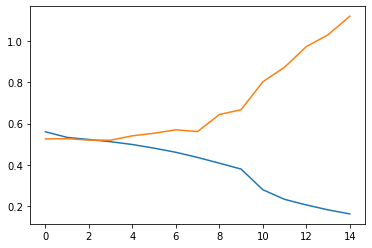

In [160]:
plt.plot(densenet_results[['training_losses', 'validation_losses']])